<a href="https://colab.research.google.com/github/agniji/DO_Campaigns/blob/main/AttribModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attribution Model



Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [1]:
import numpy as np
import pandas as pd
import re

import plotly.express as px
from collections import Counter
from sklearn import metrics


In [42]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error


In [2]:
from google.colab import drive

drive.mount("/content/gdrive")

%pwd

Mounted at /content/gdrive


'/content'

In [3]:
#Add shortcut of AgeptID to My Drive
%cd gdrive/My\ Drive/DO

/content/gdrive/.shortcut-targets-by-id/1tH2Ib5soHg-2oTfRvExTKgtRzMqtjs6d/DO


In [67]:
#TRAIN Data
df = pd.read_csv("Do.csv")


In [68]:
df.head(5)

,session_id,user_id,event_ts,event_name,utm_source,utm_content,utm_medium,utm_campaign,utm_term,page,referrer,session_start_ts,session_end_ts,channel_id,Sign_up
0,433,1,2024-01-01 9:37:00,page,google,NaN,cpc,Performance Max-H100,a100 graphics card,H100 GPUs Are Available Now,https://www.google.co.in/,2024-01-01 9:37:00,2024-01-01 9:45:45,adwords_search,False
1,3662,1,2024-02-01 22:55:00,page,blank,NaN,NaN,NaN,nvidia a100 buy,The GPU cloud built for Machine Learning | Pap...,NaN,2024-02-01 22:55:00,2024-02-01 23:08:44,web_referral,False
2,2053,1,2024-02-09 3:18:00,page,google,NaN,cpc,Performance Max-H100,a100 graphics card,H100 GPUs Are Available Now,https://www.google.co.in/,2024-02-09 3:18:00,2024-02-09 3:33:19,adwords_search,False
3,1349,1,2024-02-10 1:37:00,page,google,NaN,cpc,Performance Max-H100,a100 graphics card,NVIDIA H100,android-app://com.google.android.googlequickse...,2024-02-10 1:37:00,2024-02-10 1:50:53,web_referral,False
4,2152,1,2024-03-03 5:54:00,page,google,NaN,cpc,Performance Max-H100,a100 graphics card,The GPU cloud built for Machine Learning | Pap...,NaN,2024-03-03 5:54:00,2024-03-03 6:06:34,web_referral,False


In [69]:
#Check the data
df.describe()

,session_id,user_id
count,5000.000000,5000.000000
mean,2500.500000,497.824600
std,1443.520003,287.750771
min,1.000000,1.000000
25%,1250.750000,246.000000
50%,2500.500000,493.000000
75%,3750.250000,750.000000
max,5000.000000,1000.000000


In [55]:
# Check for missing values in each column

missing_values = df.isna().sum(axis=0)

print("Missing values in each column:")
print(missing_values)

Missing values in each column:
session_id             0
user_id                0
event_ts               0
event_name             0
utm_source             0
utm_content         4700
utm_medium          1488
utm_campaign        1684
utm_term               0
page                   0
referrer             529
session_start_ts       0
session_end_ts         0
channel_id            30
Sign_up                0
dtype: int64


In [56]:
# Find out value counts for each categorical col in the data
# Imbalanced data w only 108 TRUE values for Sign_up

categorical_columns = ['utm_content', 'utm_medium', 'utm_campaign', 'utm_source', 'utm_term', 'page', 'referrer', 'channel_id', 'Sign_up']

# Loop through each categorical column and print value counts
for col in categorical_columns:
    print("Value counts for column", col)
    print(df[col].value_counts())
    print("=========================")

Value counts for column utm_content
coreweave                                    126
A100                                         119
desktop - cloud platform built for future     55
Name: utm_content, dtype: int64
Value counts for column utm_medium
cpc         3261
referral     196
ppc           55
Name: utm_medium, dtype: int64
Value counts for column utm_campaign
Performance Max-H100            3016
Search_Nvidia_A100_emea           88
Search_Nvidia_A100_amer           83
Search_Search_Nvidia_A100_In      74
P - Traffic - Prospecting         55
Name: utm_campaign, dtype: int64
Value counts for column utm_source
google        3016
blank         1488
bing           245
do-top-hat     196
reddit          55
Name: utm_source, dtype: int64
Value counts for column utm_term
nvidia a100 buy       2480
a100 graphics card    2349
a100 nvidia             88
A100 Nvidia             30
nvidia a100 gpu         29
A100 graphics card      24
Name: utm_term, dtype: int64
Value counts for column page

In [57]:
#Feature Creation: Time Spent per session

df['session_start_ts'] = pd.to_datetime(df['session_start_ts'])
df['session_end_ts'] = pd.to_datetime(df['session_end_ts'])

# Add time spent per session

df['sess_time_mins'] = ((df['session_end_ts'] - df['session_start_ts']).dt.total_seconds() / 60 ).round(1)

#df.head(5)

In [58]:
# Drop columns w too many missing or meaningless data

# List of columns to drop
columns_to_drop = ['session_id', 'user_id', 'event_ts', 'event_name', 'referrer', 'utm_content', 'session_start_ts', 'session_end_ts']

# Drop the specified columns
df = df.drop(columns=columns_to_drop)

#df.head(5)

In [59]:
# Drop missing rows

#df = df.drop(columns="sess_time")

df_cleaned = df.dropna(subset=['utm_medium', 'utm_campaign', 'channel_id'])

# Convert the Target col to Boolean

df_cleaned['Sign_up'] = df_cleaned['Sign_up'].astype(bool)

missing_values = df_cleaned.isna().sum(axis=0)

print("Missing values in each column:")
print(missing_values)

df_cleaned.head(5)


Missing values in each column:
utm_source        0
utm_medium        0
utm_campaign      0
utm_term          0
page              0
channel_id        0
Sign_up           0
sess_time_mins    0
dtype: int64


<ipython-input-59-42fdd08f7fc0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Sign_up'] = df_cleaned['Sign_up'].astype(bool)


,utm_source,utm_medium,utm_campaign,utm_term,page,channel_id,Sign_up,sess_time_mins
0,google,cpc,Performance Max-H100,a100 graphics card,H100 GPUs Are Available Now,adwords_search,False,8.8
2,google,cpc,Performance Max-H100,a100 graphics card,H100 GPUs Are Available Now,adwords_search,False,15.3
3,google,cpc,Performance Max-H100,a100 graphics card,NVIDIA H100,web_referral,False,13.9
4,google,cpc,Performance Max-H100,a100 graphics card,The GPU cloud built for Machine Learning | Pap...,web_referral,False,12.6
5,google,cpc,Performance Max-H100,nvidia a100 buy,Cloud GPUs & Hosting for AI | Paperspace,web_referral,False,5.2


In [70]:
# Write the DataFrame to a CSV file
df_cleaned.to_csv('do_cleaned.csv', index=False)

In [60]:
# Get Dummies for each category for explaiinng importances for Campaign & Channel ID

# Create dummy variables

cols = ['utm_campaign', 'channel_id']

for col in cols:
  dummy_df = pd.get_dummies(df_cleaned[col]) # , prefix='Category'

  # Concatenate the dummy variables with the original DataFrame
  df_cleaned = pd.concat([df_cleaned, dummy_df], axis=1)


In [61]:
df_dummies = df_cleaned.drop(columns=["channel_id", "utm_campaign"])

df_dummies.head(5)

,utm_source,utm_medium,utm_term,page,Sign_up,sess_time_mins,P - Traffic - Prospecting,Performance Max-H100,Search_Nvidia_A100_amer,Search_Nvidia_A100_emea,Search_Search_Nvidia_A100_In,adwords_search,reddit_ads,web_referral
0,google,cpc,a100 graphics card,H100 GPUs Are Available Now,False,8.8,0,1,0,0,0,1,0,0
2,google,cpc,a100 graphics card,H100 GPUs Are Available Now,False,15.3,0,1,0,0,0,1,0,0
3,google,cpc,a100 graphics card,NVIDIA H100,False,13.9,0,1,0,0,0,0,0,1
4,google,cpc,a100 graphics card,The GPU cloud built for Machine Learning | Pap...,False,12.6,0,1,0,0,0,0,0,1
5,google,cpc,nvidia a100 buy,Cloud GPUs & Hosting for AI | Paperspace,False,5.2,0,1,0,0,0,0,0,1


In [34]:
df_dummies.columns

Index(['utm_source', 'utm_medium', 'utm_term', 'page', 'Sign_up',
       'sess_time_mins', 'P - Traffic - Prospecting', 'Performance Max-H100',
       'Search_Nvidia_A100_amer', 'Search_Nvidia_A100_emea',
       'Search_Search_Nvidia_A100_In', 'adwords_search', 'reddit_ads',
       'web_referral'],
      dtype='object')

In [40]:
# Build the LGB Model w cleaned dummified data

# Split the data into features and target
X = df_dummies.drop('Sign_up', axis=1)
y = df_dummies['Sign_up']

# Convert categorical columns to the 'category' data type
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype('category')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=X_train.select_dtypes(include='category').columns.tolist())
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=X_train.select_dtypes(include='category').columns.tolist())

# Specify the parameters for the LightGBM classifier
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the model
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

# Make predictions
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy:", accuracy)

# Calculate the AUC score
auc = roc_auc_score(y_test, y_pred)
print("Area Under teh Curve:", auc)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 60, number of negative: 2568
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 2628, number of used features: 13
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022831 -> initscore=-3.756538
[LightGBM] [Info] Start training from score -3.756538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

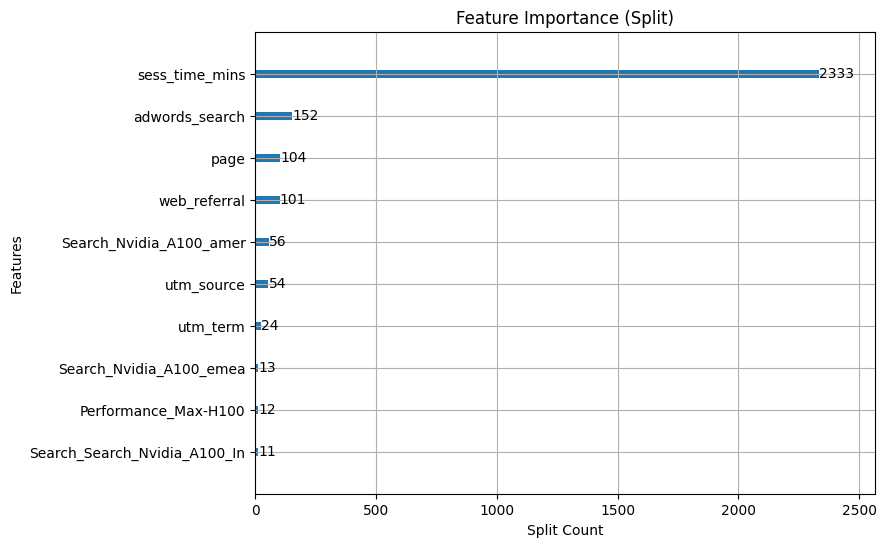

In [41]:
lgb.plot_importance(bst, importance_type='split', title='Feature Importance (Split)', xlabel='Split Count', ylabel='Features', figsize=(8, 6))
plt.show()

In [43]:
#Build Regression Model for predicting Session Time Spend

df2 = df_dummies.drop(columns='Sign_up')

# Split the data into features and target
X = df2.drop('sess_time_mins', axis=1)
y = df2['sess_time_mins']

# Convert categorical columns to the 'category' data type
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype('category')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=X_train.select_dtypes(include='category').columns.tolist())
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=X_train.select_dtypes(include='category').columns.tolist())

# Specify the parameters for the LightGBM regressor
params = {
    'objective': 'regression',
    'metric': 'mse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the model
num_round = 100
reg_lgb = lgb.train(params, train_data, num_round, valid_sets=[test_data])

# Make predictions
y_pred = reg_lgb.predict(X_test, num_iteration=reg_lgb.best_iteration)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33
[LightGBM] [Info] Number of data points in the train set: 2628, number of used features: 12
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 10.083333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [47]:
feature_importance = reg_lgb.feature_importance()

# Print feature importance
for i, feature_name in enumerate(X.columns):
    print(f"{feature_name}: {feature_importance[i]}")

utm_source: 218
utm_medium: 18
utm_term: 179
page: 653
P - Traffic - Prospecting: 0
Performance Max-H100: 27
Search_Nvidia_A100_amer: 82
Search_Nvidia_A100_emea: 80
Search_Search_Nvidia_A100_In: 58
adwords_search: 431
reddit_ads: 0
web_referral: 159


In [52]:
# Feature Importances & Display results in Descending order

# Scaling by total splits
feature_importance = (feature_importance) / (feature_importance.sum() )

imp_reg = dict()

for i, feature_name in enumerate(X.columns):
  imp_reg[feature_name] = feature_importance[i]

sorted_dict = dict(sorted(imp_reg.items(), key=lambda kv: kv[1], reverse=True))

# Print the sorted dictionary
for k, v in sorted_dict.items():
  print(k, " : ", v)

page  :  0.34278215223097114
adwords_search  :  0.226246719160105
utm_source  :  0.11443569553805776
utm_term  :  0.09396325459317585
web_referral  :  0.08346456692913386
Search_Nvidia_A100_amer  :  0.04304461942257218
Search_Nvidia_A100_emea  :  0.041994750656167985
Search_Search_Nvidia_A100_In  :  0.030446194225721788
Performance Max-H100  :  0.014173228346456693
utm_medium  :  0.009448818897637795
P - Traffic - Prospecting  :  0.0
reddit_ads  :  0.0
